<a href="https://colab.research.google.com/github/jvataidee/DataAnalysis/blob/master/Analise_Financeira_Mercado_Gado_de_Corte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_ce7cb603d09d4263921dda3fb68a395f~mv2.png" height="75px"></p>

**by: [João Ataíde](https://www.joaoataide.com)**
# Análise Mercado Financeira de Gado de Corte


---

<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_a59ef6dfb8914eea869878888a5d0acd~mv2.jpg"></p>



In [15]:
!pip install investpy -q

In [107]:
#importar bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importar bibliotecas financeiras
import investpy
import yfinance as yf

# configurar a visualização
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## O que são commodities?

- Live Cattle - Boi Gordo
- Feeder Cattle - Bezerro

In [100]:
commodities = ["Live Cattle", "Feeder Cattle", ]

inicio = "01/07/2014"
fim = "01/07/2021"

In [101]:
#Importando dados das commodities
def commodities_df(commodities, inicio,fim):
  precos = pd.DataFrame()
  for i in commodities:
    df = investpy.commodities.get_commodity_historical_data(commodity=i, from_date=inicio, to_date=fim).Close
    df.rename(i, inplace=True)
    df.columns = [i]
    precos = pd.concat([precos,df], axis=1)
    precos.index.name="Date"
  return precos

In [104]:
df = commodities_df(commodities,inicio,fim)
df.head()

,Live Cattle,Feeder Cattle
Date,,
2014-07-01 00:00:00,151.500,215.78
2014-07-02 00:00:00,152.325,216.20
2014-07-03 00:00:00,155.000,217.62
2014-07-07 00:00:00,154.950,218.00
2014-07-08 00:00:00,153.525,215.90


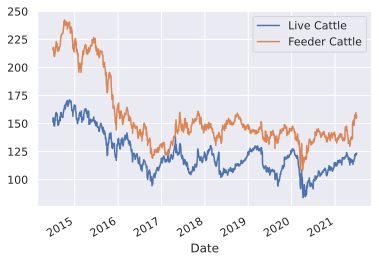

In [106]:
df.plot();

In [124]:
#Importar historico do dollar
doll = yf.Ticker("USDBRL=x")
dollar = pd.DataFrame(doll.history(start ="2014-07-01", end ="2021-07-01" ).Close)
dollar.columns = ["Dollar"]
dollar.index.name="Date"
dollar.head()

,Dollar
Date,
2014-07-01,2.2117
2014-07-02,2.1981
2014-07-03,2.2223
2014-07-04,2.2068
2014-07-07,2.2098


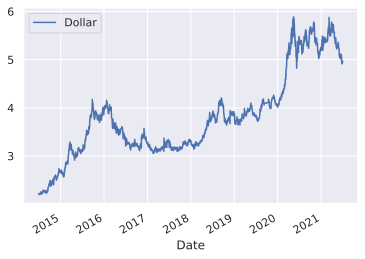

In [125]:
dollar.plot()